## Zonal Statistics in python

This notebook shows how to compute the median of raster values for each NUTS-X polygon.
It consider two different input data types:
1. **NetCDF file**, common format in climate data which usually contains enough geographical information to be able to perform geographical analysis.
2. **Npy file**, which is the "raw" numpy format for multi-dimensional arrays. In this case, it is necessary an affine transformation before performing zonal statistics.

Input needed: 
1. NetCDF file for the raster, containing the drought frequency information or npy file contains nd-arrays.
2. NUTSID shapefiles, one for each level needed.

In [1]:
# LIST OF IMPORTS

# to work with multidimensional arrays and to import NetCDF files
import xarray
# extension of xarray to convert ndarrays to raster
import rioxarray
# python module to computer statistics
from rasterstats import zonal_stats
# to suppress warnings on large loops
import warnings
# to wrap function
from functools import wraps
# to calculate execution time
import time
# to create the final table
import pandas as pd
# for the affine transformation
from affine import Affine
# for os miscellaneous
import os
# for numpy arrays
import numpy as np
# to create tiff image
import rasterio

In [2]:
# Path to our input NetCDF file
historical_drought = r"E:\mottaco\Documents\JRC\3. Data\1. Drought\Raster\historical_dis_mon7dMeanMin_EFFAS_year_statistics.nc"
# Path to our NUTS-X shapefiles
nuts_shp = r"E:\mottaco\Documents\JRC\3. Data\1. Drought\Shapefiles\NUTS\3.shp"

### Input data in NetCDF format
If the input drought frequency data are in `netcdf` format, first we import them using xarray

In [3]:
ds_disk = xarray.open_dataset(historical_drought)

In [4]:
ds_disk

<xarray.Dataset>
Dimensions:        (return_period: 21, y: 950, x: 1000, ix: 1000, iy: 950,
                    nretper: 21, year: 27, iyear: 27)
Coordinates:
    x              (ix) float64 ...
    y              (iy) float64 ...
    return_period  (nretper) float64 ...
    year           (iyear) float64 ...
Dimensions without coordinates: ix, iy, nretper, iyear
Data variables: (12/15)
    rl             (return_period, y, x) float64 ...
    se_rl          (return_period, y, x) float64 ...
    shape_fit      (y, x) float64 ...
    se_shape       (y, x) float64 ...
    scale_fit      (y, x) float64 ...
    se_scale       (y, x) float64 ...
    ...             ...
    lat            (y, x) float64 ...
    le             (year, y, x) float64 ...
    rp             (year, y, x) float64 ...
    se_rp_sup      (year, y, x) float64 ...
    se_rp_inf      (year, y, x) float64 ...
    frq            (year, y, x) float64 ...

Note that we have 15 Data variables, including lat and lon in epsg:4326. The coordinates, however, are named x and y with dimensions respectively of ix and iy. This means that i have both __logical__ coordinates (ix and iy) and __physical__ coordinates (x and y). Physical coordinates, in this case, are the geographical ones. We know that the used projection for them is ETRS_1989_LAEA, epsg:3035.

As i am interested in the __frq__ variable, for each year of the dataset, i need to extract a DataArray that contains only these information and that is correctly georeferenced. There are two possible ways.

1. Extract directly from the dataset
2. Create a new DataArray and pass to the constructor the data that i need from the dataset.

We use the second option in this case:

In [5]:
frq_da = xarray.DataArray(
    ds_disk.frq.data, # first the data frq is a multi-dimensional array --> ('year', 'y', 'x')
    coords={
        "year": ds_disk.year.data, # year coords
        "y": ds_disk.y.data, # lat coords
        "x": ds_disk.x.data, # lon coords
    },
    dims=["year", "y","x"], # finally the dims
)

In [6]:
frq_da.y.max()

<xarray.DataArray 'y' ()>
array(5497500.)

Now we have an xarray __DataArray__ object. We also want to include the crs information so that it can be used later on to perform the zonal statistics. We use rioxarray to write the information in a _CF_ compliant way

In [7]:
frq_da.rio.write_crs("epsg:3035", inplace=True)

<xarray.DataArray (year: 27, y: 950, x: 1000)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * year         (year) float64 1.99e+03 1.991e+03 ... 2.015e+03 2.016e+03
  * y            (y) float64 5.498e+06 5.492e+06 ... 7.575e+05 7.525e+05
  * x            (x) float64 2.502e+06 2.508e+06 ... 7.492e+06 7.498e+06
    spatial_ref  int32 0

Let's see one plot for one year to control that the data looks like expected:

In [8]:
#frq_da = frq_da.fillna(1)

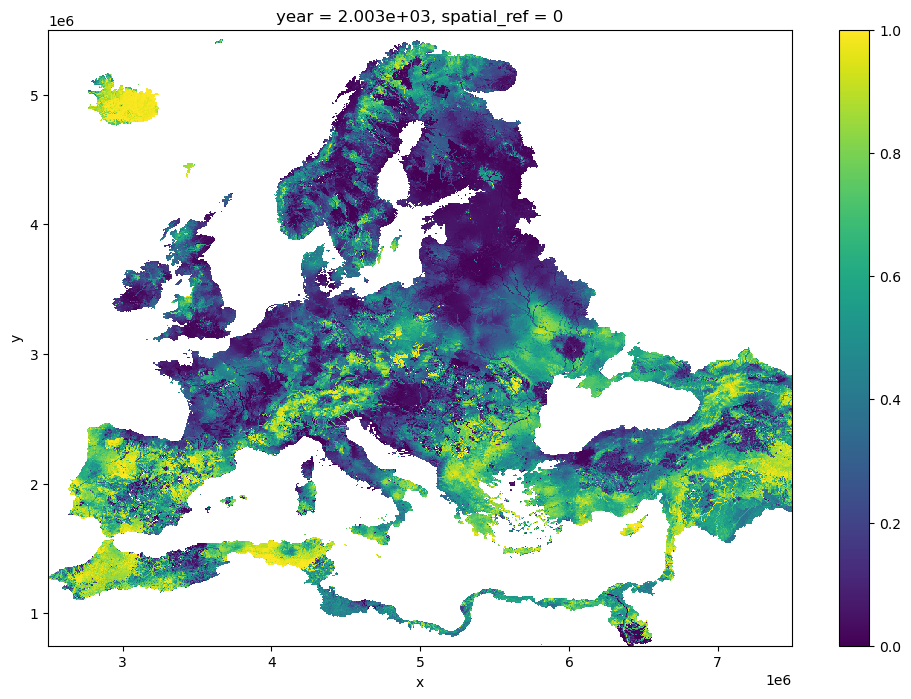

In [9]:
# select year 1996 by index
frq_da.sel(year=2003).plot(x="x", y ="y", figsize=(12,8))

if needed, I can also export the new data array in NetCDF format:

In [10]:
# uncomment to save as nc
#frq_da.to_netcdf("frequency.nc")

I can also create a geotiff out of it, for example for year 1990

In [11]:
# uncomment to save as tiff
frq_da.sel(year=2003).rio.to_raster("2003.tiff")

At the end, to perform the zonal statistics in the fastest way, i need to have the following information for the drought data:

1. Numpy 2D array (therefore i need to select a specific year)
2. Affine transformation to be used for the zonal statistics

Both of them can be found in the NetCDF data and metadata.

### Input data in npy format

If the input drought frequency data are in `npy` format, we need to open it as a numpy array, do geometrical trasformation (if needed) and find the correct Affine transformation info.

In [12]:
projection_drought = r"C:\Users\mottaco\SCRIPTS\lisfloodRunManager-master\CORDEXRuns\lowFlowWarmSeason\Results\Diagnostics"
npy = projection_drought
fname = r"droughtFrqDiagnostics_CLMcom-CCLM4-8-17_BC_CNRM-CERFACS-CNRM-CM5_rcp45_1983.0.npy"

In [13]:
fname

'droughtFrqDiagnostics_CLMcom-CCLM4-8-17_BC_CNRM-CERFACS-CNRM-CM5_rcp45_1983.0.npy'

In [14]:
# let's take only the first as an example
#fname = os.listdir(projection_drought)[1]
npy = os.path.join(projection_drought,fname)

In [15]:
# load and transform
myArray = np.load(npy)
myArray=np.fliplr(myArray)
myArray=np.rot90(myArray)

Now we need to set the correct Affine transformation. That is fundamental information to be able to run the zonal statistics. We also need to have the correct CRS if we want to export as geotiff too.

For more information on how the Affine transformation works, please refer to https://www.perrygeo.com/python-affine-transforms.html

In [16]:
frq_aff = Affine(5000.0, 0.0, 2500000.0, 0.0, -5000.0, 5500000.0)
frq_crs = 'epsg:3035'

With this information i can create the raster image and save it as a tiff

In [17]:
# create the metadata for the raster
meta = {'driver': 'GTiff',
        'dtype': 'float64',
        'nodata': -9999.0,
        'width': 1000,
        'height': 950,
        'count': 1,
        'crs': 'epsg:3035',
        'transform': frq_aff}

# write the data to a raster file
with rasterio.open("{0}_run2.tif".format(fname), 'w', **meta) as dst:
    dst.write(myArray, 1)

the raster can be opened in QGIS or here, using rasterio, to check that the transformation has been applied correctly.

## Perform zonal statistics
Zonal statistics is a method of summarizing and aggregating the raster values intersecting a vector geometry. 

In this example, we use the netcdf input. It is the same to use the npy one, the affine info and the array should be changed accordingly.
To increase speed we would like to pass to rasterstats a numpy ndarray containing only the needed raster information.
Here we do an example with year 1990


In [18]:
frq_nd = frq_da.isel(year=0).to_numpy()

In [19]:
frq_nd.shape

(950, 1000)

If i use a numpy ndarray i need to attach an affine transform mapping the array dimensions to a coordinate reference system. To calculate the affine transformation we need the CRS info. That is why we attached them to the DataArray before.

In [20]:
# calculate affine transformation
frq_aff = frq_da.rio.transform()

In [21]:
frq_aff

Affine(5000.0, 0.0, 2500000.0,
       0.0, -5000.0, 5500000.0)

Finally using `zonal_stats` method of rasterstats, i can calculate the zonal statistics for each NUTS area!

In [22]:
# suppress warnings to avoid long outputs on notebook
warnings.filterwarnings('ignore')

Let's also calculate the execution time

In [23]:
start_time = time.perf_counter()
frq_zonal = []
for i, year in enumerate(frq_da.year):
    #print(i,int(yea.data))

    tmp_zonal = zonal_stats(nuts_shp, # NUTS shapefile
                         frq_da.isel(year=i).to_numpy(), # our ndarray
                         stats="median", # we are interested only in median values
                         affine=frq_aff, # affine transformation
                         geojson_out=True # to add info from shp fields
                        )
    frq_zonal.extend([(int(year.data),obj['properties']["NUTS_ID"],float(obj['properties']["median"])) for i,obj in enumerate(tmp_zonal) if obj['properties']["median"] is not None])
end_time = time.perf_counter()
total_time = end_time - start_time
print(f'Execution time {total_time:.4f} seconds')

Execution time 137.9823 seconds


We can now print the median values for the NUTS regions in Italy. `frq_zonal` is a list of _fiona_ features. We have one feature for each NUTS_ID

In [24]:
df = pd.DataFrame(frq_zonal, columns=['year', 'NUTS_ID', 'med'])

In [25]:
df.head(10)

,year,NUTS_ID,med
0,1990,NO0B1,0.274340
1,1990,HR064,0.232160
2,1990,DE21A,0.665671
3,1990,DE94E,0.392419
4,1990,DE94F,0.421284
5,1990,DE94G,0.628464
6,1990,DEA59,0.106098
7,1990,DE139,0.010772
8,1990,AL034,0.016986
9,1990,DE226,0.000730


In [26]:
# uncomment to export to a CSV or a parquet
#df.to_csv(r"csv/historical_drought_python.csv", index=False)
#df.to_parquet('historical_drought_python.parquet', engine='fastparquet')